[742. 491.]
actor using:  cpu
Critic using:  cpu
[747. 491.]
... loading models ...
...running...


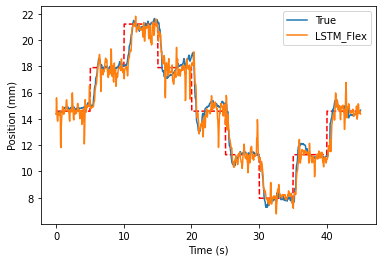

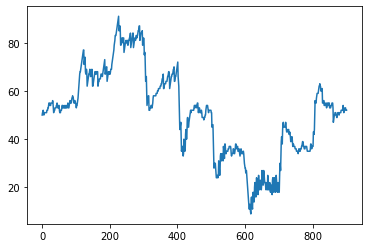

In [1]:
import matplotlib.pyplot as plt
import gym
import numpy as np
from ppo_torch_conv1d import Agent
from utils import plot_learning_curve
import tensorflow as tf
import time

###### SEPARATE ENVIRONMENTS FOR DIFFERENT STATE INFERENCE METHODS. (CHOOSE ONE) ###########

import MFC_aileron_env_discrete_pytorch_variable_target_LSTM_flex_to_laz_10obs_CONNECTED as mfc_env  #LSTM inference
#import MFC_aileron_env_discrete_pytorch_variable_target_simple_flex_to_laz_10obs_CONNECTED as mfc_env #LIN inference
#import MFC_aileron_env_discrete_pytorch_variable_target_laz_10obs_CONNECTED as mfc_env  #True observations


env = mfc_env.MFC_aileron_Env()
N = 20
batch_size = 5
n_epochs = 4
alpha = 0.00003
steps_per_test_ep = 100
spe = steps_per_test_ep
goals = [0, 0.5, 1, 0.5, 0, -0.5, -1, -0.5, 0]
goal_len = len(goals)
dwait = 0
delt = 0.05
last_dt = 0

if __name__ == '__main__':
    
    ################ LAST LINE OF AGENT INPUTS DEFINE IF USING THE TRADITIONAL RL CONTROLLER  #####
    ################# OR THE MITIGATING OVERSHOOT (MO) CONTROLLER. (CHOOSE ONE)    #######
    
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape, 
                    fc1_dims=512, fc2_dims=512, chk_dir='tmp/ppo/10obs_AUG5') #RL controller
                    #fc1_dims=512, fc2_dims=512, chk_dir='tmp/ppo/10obs_no_overshoot_SEP6') #MO controller
                    

    states = np.zeros((steps_per_test_ep*goal_len+1, 4))
    lazer_obs = np.zeros(steps_per_test_ep*goal_len+1)
    observation, laz = env.reset()
    states[0,:] = observation[:,-1]
    lazer_obs[0] = laz
    agent.load_models(end=True)
    print('...running...')
    prev_time = time.time()
    timesteps = [0]
    for ii, g in enumerate(goals):
        env.next_goal(g)
        for i in range(steps_per_test_ep):
            action, prob, val = agent.choose_action(observation, avg=True)
    
            observation_, dt, done, lazer_obs[ii*spe+i+1] = env.step(action)
            timesteps=np.append(timesteps, timesteps[ii*spe+i]+dt)
            observation = observation_
            states[ii*steps_per_test_ep+i+1,:] = observation[:,-1]
    
    env.end()
            
    
    plt.plot(timesteps, (states[:,3]*226+497.5)*30/1023, '--r')
    plt.plot(timesteps, lazer_obs*30/1023, label='True')
    plt.plot(timesteps, (states[:,0]*226+497.5)*30/1023, label='LSTM_Flex')
    plt.xlabel('Time (s)')
    plt.ylabel('Position (mm)')
    plt.legend()
    plt.show()
    plt.plot(np.arange(steps_per_test_ep*goal_len+1), states[:,2]*26.8+50)
    plt.show()